In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_ = ".\\..\\data"
images_folder = os.path.join(data_, "images")
labels_folder = os.path.join(data_, "labels")


In [3]:
def get_all_coords(box):
    x = []
    y = []

    #coords are taken in clockwise direction
    x += [box[0], box[2], box[2], box[0]]
    y += [box[1], box[1], box[3], box[3]]

    return [x, y]

In [4]:
import os
import torch
import json
from PIL import Image
from torch.utils.data import Dataset


class RecieptDataset(Dataset):
    def __init__(self, root_dir, box_orientation = None, transform=None):
        super(RecieptDataset, self).__init__()

        self.root_dir = root_dir
        self.transform = transform
        self.box_orientation = box_orientation

        #find all image files
        self.image_names = [path for path in os.listdir(self.root_dir) if path.endswith(".jpg")]

    def __len__(self):
        return len(self.image_names)

    #TODO: Read docs and paper on image transform and normalization
    def __getitem__(self, idx):
        
        img_name = self.image_names[idx]
        label_name = img_name[:-4]+".json"

        img = Image.open(os.path.join(self.root_dir, img_name))
        label_name = json.load(open(os.path.join(self.root_dir, label_name)))

        bnd_boxes = []
        for label in label_name:
            if self.box_orientation is not None:
                #For AABB boxes
                bnd_boxes.append([min(label['x']), min(label['y']), max(label['x']), max(label['y']), self.box_orientation])
            else:
                #TODO: Add support of RBOX
                bnd_boxes.append([min(label['x']), min(label['y']), max(label['x']), max(label['y'])])

        if self.transform is not None:
            bnd_boxes = torch.Tensor(bnd_boxes)
            img, bnd_boxes = self.transform(img, bnd_boxes)

        return [img, bnd_boxes]


root_dir = "E:\\Projects\\2020\\OCR\\EAST\\data\\processed_data"

dataset = RecieptDataset(root_dir)
        

In [5]:
img, bnd_box = dataset.__getitem__(3)

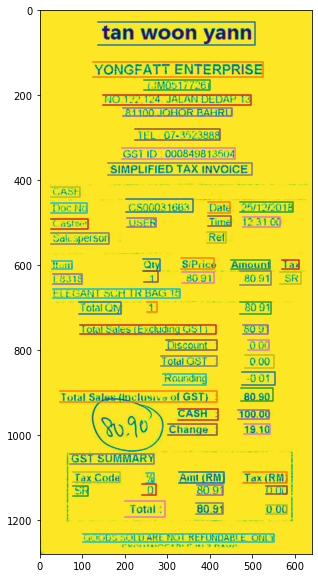

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(img)

for box in bnd_box:
    box = get_all_coords(box)
    plt.plot(box[0], box[1])

In [22]:
def scale_rectangle(box, scale):

    if type(box) == list:
        box = np.array(box)
    
    center = np.sum(box, axis=1)/4
    center = np.expand_dims(center, axis=1)
    cen_box = box - center
    cen_box = scale*cen_box

    box = cen_box + center

    return box.astype(int)


def map_score(score, box):
    h = box[1][3] - box[1][0]
    w = box[0][1] - box[0][0]

    score[box[1][0]:box[1][0]+h, box[0][0]:box[0][0]+w] = 1

    return score


def scale_bnd_boxes(box, scale_X, scale_Y):
    if isinstance(box, list):
        box = np.array(box)
    
    box[0] = box[0]*scale_X
    box[1] = box[1]*scale_Y

    return box

def create_score_map(img, boxes, scale = 0.25):
    
    old_width, old_height = img.size
    new_width, new_height = int(old_width*scale), int(old_height*scale)

    score = np.zeros((new_height, new_width))
    scale_X = new_width/old_width
    scale_Y = new_height/old_height

    for box in bnd_box:
        box = get_all_coords(box)
        box = scale_bnd_boxes(box, scale_X, scale_Y)
        scaled_box = scale_rectangle(box, 0.7)
        score = map_score(score, scaled_box)

    return score



In [23]:
score = create_score_map(img, bnd_box, scale = 0.25)

In [27]:
scale = 0.25

old_width, old_height = img.size
new_width, new_height = int(old_width*scale), int(old_height*scale)

scale_X = new_width/old_width
scale_Y = new_height/old_height


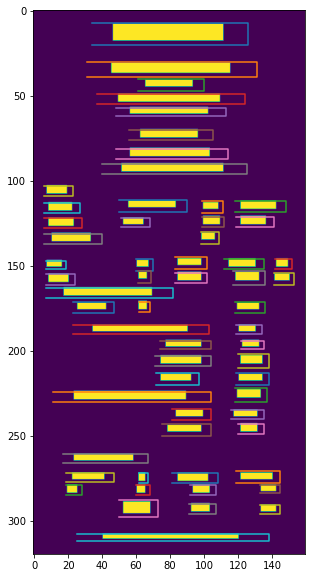

In [28]:
plt.figure(figsize=(10, 10))
plt.imshow(score)

for box in bnd_box:
    box = get_all_coords(box)
    box = scale_bnd_boxes(box, scale_X, scale_Y)
    plt.plot(box[0], box[1])

In [105]:
score.shape

(1280, 640)

In [31]:
def create_geometry_map(img, boxes, scale):

    old_width, old_height = img.size
    new_width, new_height = int(old_width*scale), int(old_height*scale)

    scale_X = new_width/old_width
    scale_Y = new_height/old_height

    left = np.zeros((new_height, new_width))
    right = np.zeros((new_height, new_width))
    top = np.zeros((new_height, new_width))
    bottom = np.zeros((new_height, new_width))
    orientation = np.zeros((new_height, new_width))

    indices = np.indices(np.array(img).shape)

    for box in boxes:
        box = get_all_coords(box)
        box = scale_bnd_boxes(box, scale_X, scale_Y)
        #left box[0][0]
        left = calculate_geometry_score(box, indices, left, box[0][0], 1)
        #right box[0][1]
        right = calculate_geometry_score(box, indices, right, box[0][1], 1)
        #top box[1][0]
        top = calculate_geometry_score(box, indices, top, box[1][0], 0)
        #bittom box[1][2]
        bottom = calculate_geometry_score(box, indices, bottom, box[1][2], 0)
    
    geometry_map = np.stack([left, top, right, bottom, orientation])

    return geometry_map

In [32]:
def calculate_geometry_score(box, indices, map_, point, idx = 0):
    
    h = box[1][3] - box[1][0]
    w = box[0][1] - box[0][0]

    geo = indices[:, box[1][0]:box[1][0]+h, box[0][0]:box[0][0]+w]
    geo = np.sqrt(np.square(point - geo[idx]))

    map_[box[1][0]:box[1][0]+h, box[0][0]:box[0][0]+w] = geo

    return map_

In [33]:
m = create_geometry_map(img, bnd_box, scale= 0.25)

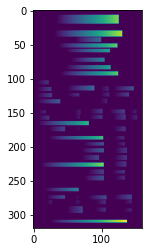

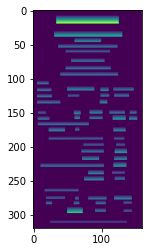

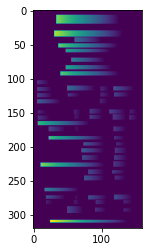

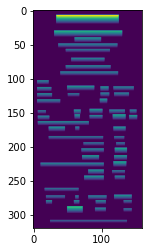

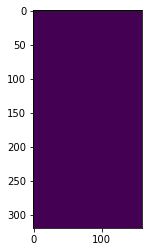

In [36]:
for i in range(len(m)):
    plt.imshow(m[i])
    plt.show()

In [39]:
np.unique(m[0])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112.])

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''